# Aplicação de Metaheurística - Ant Colony Optimization
### Kawan Oliveira
---
O objetivo deste trabalho é aplicar uma metaheurística para resolver um problema real ou
acadêmico definido pelo próprio aluno.

O trabalho deve envolver programação prática em Python, com a devida explicação do
método utilizado e análise dos resultados.


## Problema e Abordagem
Este projeto resolve o **Problema de Roteamento de Veículos (VRP)**, que consiste em encontrar rotas otimizadas para uma frota de veículos atender um conjunto de clientes, minimizando a distância total percorrida e respeitando restrições como a capacidade dos veículos.

O VRP é uma generalização do clássico Problema do Caixeiro Viajante (TSP), estendendo-o para múltiplos veículos e cenários logísticos reais.

Para resolver esse problema, foi utilizada a metaheurística **Ant Colony Optimization (ACO)**, inspirada no comportamento de formigas ao buscar caminhos eficientes. Cada "formiga" constrói soluções baseadas em feromônio (memória do caminho) e heurísticas (distância). Quando um veículo atinge sua capacidade, a formiga retorna ao depósito e inicia uma nova rota.

A escolha do próximo cliente é baseada na fórmula:
$$
p_{ij} = \frac{[\tau_{ij}]^\alpha \cdot [\eta_{ij}]^\beta}{\sum\limits_{k \in \text{clientes não visitados}} [\tau_{ik}]^\alpha \cdot [\eta_{ik}]^\beta}
$$

**Onde:**
- $\tau_{ij}$: quantidade de feromônio na aresta $i \rightarrow j$  
- $\eta_{ij}$: valor heurístico (inverso da distância)  
- $\alpha$, $\beta$: parâmetros que controlam a influência do feromônio e da heurística, respectivamente

Após a construção das soluções, o feromônio é atualizado com base nas melhores rotas encontradas, promovendo o equilíbrio entre exploração de novas rotas e reforço das boas soluções.

### Baixando as bibliotecas necessárias

In [ ]:
#Instalação das bibliotecas
%pip install numpy matplotlib

### Carregando as bibliotecas necessárias

In [3]:
#Carregando as bibliotecas
import numpy as np
import random
import matplotlib.pyplot as plt

### Resolvendo o problema com ACO

Iniciaremos resolvendo uma versão simplificada do problema, considerando apenas um único veículo responsável por atender todas as demandas. Essa configuração aproxima-se do clássico Problema do Caixeiro Viajante (TSP), servindo como base para uma futura expansão ao cenário completo com múltiplos veículos e restrições adicionais.

> Vale destacar que: a cada nova execução, o resultado pode variar um pouco devido as seeds de geração das coordenadas, o que implica que os resultados vistos nesta execução, podem estar diferentes dos mostrados no relatório em PDF.

In [4]:
#Definição de parâmetros do problema
num_clients = 25 #número de clientes que devem ser visitados.
vehicle_count = 1 #número de veículos disponíveis (neste caso, apenas 1).
vehicle_capacity = 250 #capacidade máxima de carga do veículo (para garantir que só 1 
                        #consiga levar tudo, coloquei 25*10=250 pois cada demanda "pesa" 10)

alpha = 1 #influência do feromônio na escolha do próximo nó.
beta = 5 #influência da visibilidade (inverso da distância).
evaporation = 0.5 #taxa de evaporação do feromônio (evita convergência prematura).
ant_count = 10 #número de "formigas" (soluções) geradas por iteração.
iterations = 100 #quantas vezes o processo será repetido para refinar a solução.

# Gerar coordenadas aleatórias para clientes e depósito
np.random.seed(42)
#define as coordenadas (x, y) para o depósito (nó 0) e os clientes (nós 1–25).
coords = {0: (50, 50)}  # depósito
for i in range(1, num_clients + 1):
    coords[i] = (np.random.randint(0, 100), np.random.randint(0, 100))

#Demandas
demands = [0] + [10 for _ in range(num_clients)] #A demanda do depósito é 0. 
                                                #Todos os 25 clientes têm demanda de 10 unidades.

# Calculo da matriz de distâncias
num_nodes = len(coords)
#Cria uma matriz distances[i][j] com a distância entre os pontos i e j.
distances = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(num_nodes):
        xi, yi = coords[i]
        xj, yj = coords[j]
        #Calcula a distância euclidiana entre todos os pares de pontos (clientes + depósito).
        distances[i][j] = np.hypot(xi - xj, yi - yj)

#Inicializa todos os caminhos com feromônio igual a 1 (estado neutro).
pheromones = np.ones((num_nodes, num_nodes))
#A matriz pheromones[i][j] representa a quantidade de feromônio entre os pontos i e j.

def construct_solution():
    unvisited = set(range(1, num_nodes))  # Clientes ainda não visitados (exclui o depósito)
    solution = []  # Lista de rotas (uma por veículo)

    for _ in range(vehicle_count):
        route = []     # Rota atual do veículo
        current = 0    # Começa no depósito
        load = 0       # Carga atual do veículo

        while True:
            # Filtra clientes que ainda não foram visitados e cabem na carga restante
            candidates = [c for c in unvisited if demands[c] + load <= vehicle_capacity]
            if not candidates:
                break  # Nenhum cliente pode ser atendido => rota termina

            # Calcula probabilidade de ir para cada cliente candidato
            probabilities = []
            for client in candidates:
                tau = pheromones[current][client] ** alpha  # feromônio
                eta = (1 / distances[current][client]) ** beta  # visibilidade (proximidade)
                probabilities.append(tau * eta)

            # Normaliza e escolhe próximo cliente com base nas probabilidades
            probabilities = np.array(probabilities)
            probabilities /= probabilities.sum()
            next_client = random.choices(candidates, weights=probabilities, k=1)[0]

            # Atualiza estado da rota
            route.append(next_client)
            unvisited.remove(next_client)
            load += demands[next_client]
            current = next_client

        if route:
            solution.append(route)

    return solution

#Cálculo do custo da solução
def route_cost(solution):
    cost = 0
    for route in solution:
        prev = 0  # depósito
        for client in route:
            #Soma as distâncias dos caminhos de ida e volta de cada veículo.
            cost += distances[prev][client]
            prev = client
        cost += distances[prev][0]  # volta ao depósito
    return cost

#Evaporação do feromônio
def evaporate_pheromones():
    global pheromones
    pheromones *= (1 - evaporation) #reduz os valores de feromônio em todas as rotas.

#Reforço das melhores soluções
def update_pheromones(solutions):
    for solution, cost in solutions:
        for route in solution:
            prev = 0
            for client in route:
                pheromones[prev][client] += 1.0 / cost
                pheromones[client][prev] += 1.0 / cost
                prev = client
            pheromones[prev][0] += 1.0 / cost
#Reforça os caminhos usados com mais feromônio (quanto melhor a solução, maior o reforço).

#-------------------------EXECUÇÃO DA ACO COM AS CHAMADAS DAS FUNÇÕES-------------------------

best_solution = None #Armazena a melhor solução encontrada até agora.
best_cost = float('inf')

for it in range(iterations):
    all_solutions = []

    #Gera várias soluções (ant_count)
    for _ in range(ant_count):
        solution = construct_solution()
        cost = route_cost(solution)
        all_solutions.append((solution, cost))
        #Atualiza a melhor encontrada.
        if cost < best_cost:
            best_solution, best_cost = solution, cost

    #Evapora e reforça feromônios.
    evaporate_pheromones()
    update_pheromones(all_solutions)

#------------------------------PRINT DO RESULTADO FINAL DA ACO------------------------------

print("Melhor solução encontrada:")
for i, route in enumerate(best_solution):
    print(f"Veículo {i+1}: depósito -> " + " -> ".join(map(str, route)) + " -> depósito")
print(f"Custo total: {best_cost:.2f}")

Melhor solução encontrada:
Veículo 1: depósito -> 21 -> 20 -> 25 -> 14 -> 12 -> 3 -> 7 -> 24 -> 10 -> 8 -> 19 -> 2 -> 9 -> 11 -> 23 -> 13 -> 17 -> 1 -> 18 -> 22 -> 5 -> 4 -> 6 -> 16 -> 15 -> depósito
Custo total: 485.09


### Plotando o melhor trajeto encontrado

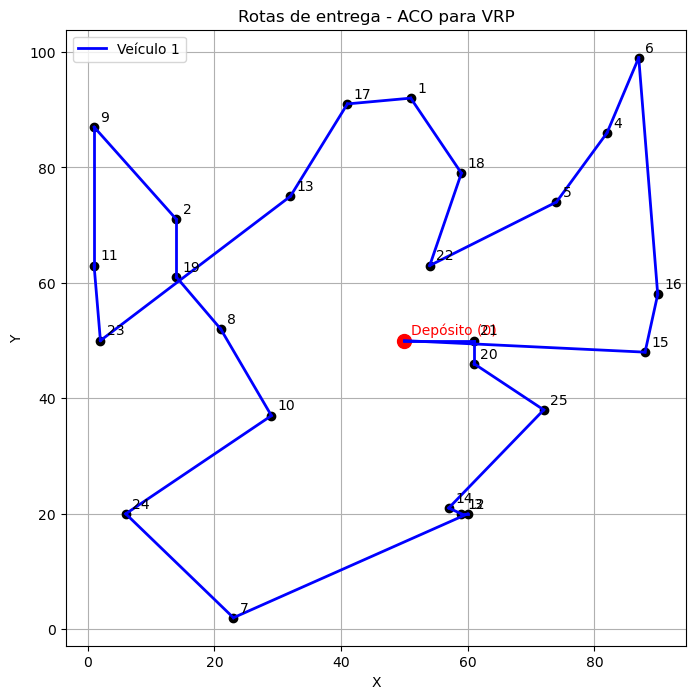

In [5]:
def plot_solution(coords, solution):
    colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink']
    plt.figure(figsize=(8, 8))

    # Desenhar todos os pontos
    for i, (x, y) in coords.items():
        if i == 0:
            plt.plot(x, y, 'ro', markersize=10)  # depósito em vermelho
            plt.text(x + 1, y + 1, f'Depósito ({i})', color='red')
        else:
            plt.plot(x, y, 'ko')
            plt.text(x + 1, y + 1, str(i))

    # Desenhar rotas
    for idx, route in enumerate(solution):
        color = colors[idx % len(colors)]
        path = [0] + route + [0]
        for i in range(len(path) - 1):
            x1, y1 = coords[path[i]]
            x2, y2 = coords[path[i+1]]
            plt.plot([x1, x2], [y1, y2], color=color, linewidth=2, label=f"Veículo {idx+1}" if i == 0 else "")

    plt.title("Rotas de entrega - ACO para VRP")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

# Chama a função de visualização
plot_solution(coords, best_solution)


Agora vamos considerar um cenário prático em que cada caminhão possui uma capacidade máxima de 100 unidades de carga, e dispomos de 3 veículos para realizar as entregas. Nosso objetivo é distribuir corretamente os 25 pacotes entre esses veículos e determinar as melhores rotas para cada um, de forma que a soma total das distâncias percorridas seja a menor possível. 

Essa situação evidencia a utilidade da abordagem com Ant Colony Optimization (ACO), pois exige a construção de múltiplas rotas viáveis, respeitando restrições de capacidade e buscando uma solução globalmente eficiente.

In [6]:
num_clients = 25
vehicle_count = 3
vehicle_capacity = 100

#-------------------------EXECUÇÃO DA ACO COM AS CHAMADAS DAS FUNÇÕES-------------------------

best_solution = None
best_cost = float('inf')

for it in range(iterations):
    all_solutions = []

    for _ in range(ant_count):
        solution = construct_solution()
        cost = route_cost(solution)
        all_solutions.append((solution, cost))
        if cost < best_cost:
            best_solution, best_cost = solution, cost

    evaporate_pheromones()
    update_pheromones(all_solutions)

#------------------------------PRINT DO RESULTADO FINAL DA ACO------------------------------

print("Melhor solução encontrada:")
for i, route in enumerate(best_solution):
    print(f"Veículo {i+1}: depósito -> " + " -> ".join(map(str, route)) + " -> depósito")
print(f"Custo total: {best_cost:.2f}")

Melhor solução encontrada:
Veículo 1: depósito -> 21 -> 20 -> 25 -> 15 -> 16 -> 5 -> 4 -> 6 -> 18 -> 1 -> depósito
Veículo 2: depósito -> 22 -> 3 -> 12 -> 14 -> 7 -> 24 -> 10 -> 8 -> 19 -> 2 -> depósito
Veículo 3: depósito -> 13 -> 17 -> 9 -> 11 -> 23 -> depósito
Custo total: 607.37


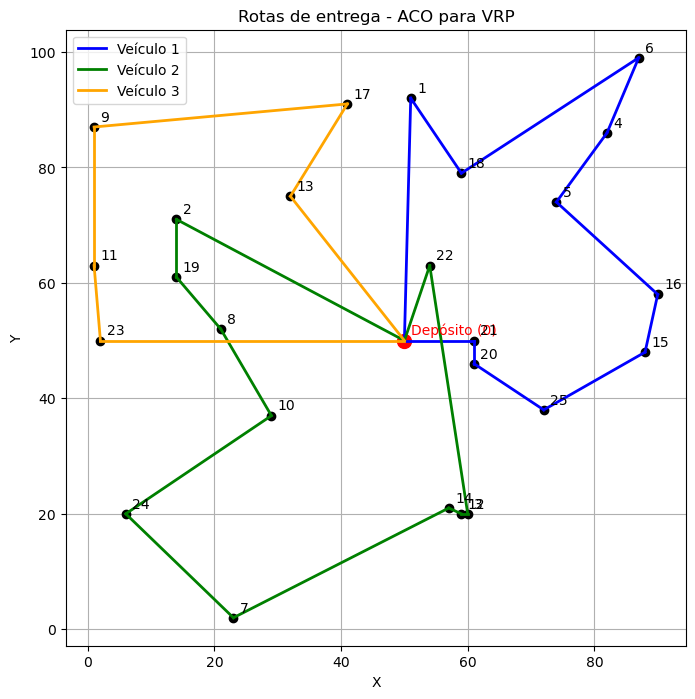

In [ ]:
# Chama a função de visualização
plot_solution(coords, best_solution)

## Análise de Cenário com Capacidade Insuficiente

### Situação Testada

Nesta simulação, temos as seguintes condições:

- 25 clientes (demanda fixa de 10 unidades).
- Capacidade total de demanda: 25 × 10 = 250 unidades.
- 3 veículos disponíveis
- Cada veículo com capacidade de 50 unidades

Total de capacidade da frota: 3 × 50 = 150 unidades.

Ou seja, a capacidade total **não é suficiente para atender todos os clientes**. Vamos ver o que ocorre em um cenário em que a capacidade total disponível seja insuficiente para atender todas as demandas.

### O que acontece neste cenário?

O algoritmo de otimização por colônia de formigas (Ant Colony Optimization - ACO) tenta construir rotas respeitando os seguintes critérios:

1. *Capacidade dos veículos: cada veículo só pode carregar até 50 unidades.
2. Probabilidade de escolha: os clientes são escolhidos com base em uma combinação de:
   - Feromônio acumulado nas rotas anteriores
   - Visibilidade (inverso da distância)
3. Não há mecanismo de garantia de cobertura total: o ACO atual **não foi projetado para forçar que todos os clientes sejam atendidos**.

---

### Comportamento Observado

Durante a execução, o algoritmo gera rotas viáveis para os veículos disponíveis, atendendo **apenas os clientes que cabem dentro da limitação de carga** da frota.

Os clientes que não foram alocados em nenhuma rota **permanecem não atendidos**, mas o algoritmo ainda considera a solução como válida.

> Isso significa que o ACO atual **minimiza o custo da melhor rota possível dentro das restrições**, mas **não penaliza nem evita deixar clientes de fora.**

Este comportamento é aceitável em casos onde:

- Há flexibilidade para realizar entregas em múltiplos dias
- Existe um sistema de replanejamento posterior

> Ou seja, o algoritmo não garante que os 3 caminhões atenderão o maior número possível de clientes, nem necessariamente os clientes que minimizariam o custo total da operação.
Por se tratar de um algoritmo metaheurístico, a solução obtida é fruto de uma aproximação estocástica, que busca boas soluções com base em heurísticas e probabilidades.
Isso significa que, embora o algoritmo seja eficaz para problemas complexos e grandes espaços de busca, ele não assegura a obtenção da solução ótima — apenas soluções viáveis e geralmente satisfatórias.
Portanto, existe uma troca entre eficiência computacional e precisão.

In [8]:
num_clients = 25
vehicle_count = 3
vehicle_capacity = 50

#-------------------------EXECUÇÃO DA ACO COM AS CHAMADAS DAS FUNÇÕES-------------------------

best_solution = None
best_cost = float('inf')

for it in range(iterations):
    all_solutions = []

    for _ in range(ant_count):
        solution = construct_solution()
        cost = route_cost(solution)
        all_solutions.append((solution, cost))
        if cost < best_cost:
            best_solution, best_cost = solution, cost

    evaporate_pheromones()
    update_pheromones(all_solutions)

#------------------------------PRINT DO RESULTADO FINAL DA ACO------------------------------

print("Melhor solução encontrada:")
for i, route in enumerate(best_solution):
    print(f"Veículo {i+1}: depósito -> " + " -> ".join(map(str, route)) + " -> depósito")
print(f"Custo total: {best_cost:.2f}")

Melhor solução encontrada:
Veículo 1: depósito -> 21 -> 20 -> 25 -> 15 -> 16 -> depósito
Veículo 2: depósito -> 13 -> 17 -> 9 -> 11 -> 23 -> depósito
Veículo 3: depósito -> 22 -> 14 -> 12 -> 3 -> 7 -> depósito
Custo total: 428.02


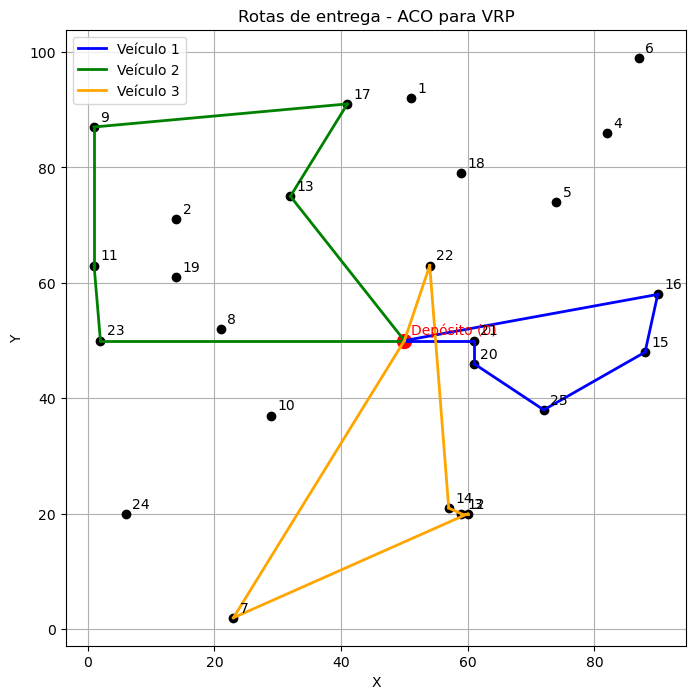

In [ ]:
# Chama a função de visualização
plot_solution(coords, best_solution)

Sendo assim, os experimentos realizados no notebook demonstraram que o ACO é uma abordagem viável e eficiente para resolver o VRP em cenários com capacidade suficiente, fornecendo soluções que respeitam as restrições operacionais e resultam em rotas curtas e bem estruturadas com um baixo custo computacional.

Contudo, é importante nos atentarmos em comportamentos subótimos, que podem ser gerados por metaheurísticas quando mal aplicadas. Isso evidencia os problemas das metaheurísticas quando são planejadas para problemas que não estão dentro de seus escopos, retornando resultados indesejados e que não fazem valer a implementação.